In [0]:
# Importing the necessary modules and printing their versions.
import pyspark 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib #
import matplotlib.pyplot as plt
#added mlflow to imports
import mlflow
import mlflow.spark

In [0]:
# data upload.PySpark has its own functionality for creating data frames.Reading the credit card data set in PySpark and
#removing the Class column from the list of columns. This is done because we don’t want the Class column to be included in the feature vector.

data_path = 'dbfs:/FileStore/tables/creditcard.csv'
#df = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/01157095@pw.edu.pl/creditcard_pyspark-2.csv")
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove("Time")
numericCols.remove(labelColumn)
print(numericCols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [0]:
# To show the records in dataset
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
Time| V1| V2| V3| V4| V5| V6| V7| V8| V9| V10| V11| V12| V13| V14| V15| V16| V17| V18| V19| V20| V21| V22| V23| V24| V25| V26| V27| V28|Amount|Class|
+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
 0.0|-1.3598071336738|-0.0727811733098497|2.53634673796914| 1.37815522427443|-0.338320769942518| 0.462387777762292| 0.239598554061257|0.0986979012610507| 0.363786969611213|0.0907941719789316|-0.551599533260813|-0.617800855762348|-0.991389847235408|-0.311169353699879| 1.46817697209427|-0.470400525259478| 0.207971241929242|0.0257905801985591| 0.403992960255733| 0.251412098239705|-0.018306777944153| 0.277837575558899|-0.110473910188767|0.0669280749146731|0.128539358273528|-0.189114843888824| 0.133558376740387|-0.0210530534538215|149.62| 0|
 0.0|1.19185711131486| 0.26615071205963|0.16648011335321|0.448154078460911|0.0600176492822243|-0.0823608088155687|-0.0788029833323113|0.0851016549148104|-0.255425128109186|-0.166974414004614| 1.61272666105479| 1.06523531137287| 0.48909501589608|-0.143772296441519|0.635558093258208| 0.463917041022171|-0.114804663102346|-0.183361270123994|-0.145783041325259|-0.0690831352230203|-0.225775248033138|-0.638671952771851| 0.101288021253234|-0.339846475529127|0.167170404418143| 0.125894532368176|-0.00898309914322813| 0.0147241691924927| 2.69| 0|
+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
only showing top 2 rows

In [0]:
# data processing procedure for PySpark is slightly different than in pandas. To train the model, we must pass in a vector called features.
# Here we define input to the assembler,so that it knows what columns to transfer into feature vectors.
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages += [assembler]

dfFeatures = df.select(F.col(labelColumn).alias('label'),*numericCols )
# Here we split the data as ps_genuine and ps_fradulent as done in scikit-learn.Since we don't perform validation test here,so we split the data in 80-20 ratio for testing #and training data.
ps_genuine = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
ps_fradulent = dfFeatures.filter("Class == 1")

ps_genuine_train, ps_genuine_test = ps_genuine.randomSplit([0.8, 0.2],seed = 2020)
ps_fradulent_train, ps_fradulent_test = ps_fradulent.randomSplit([0.8, 0.2],seed = 2020)

In [0]:
# Split data set in to training and test is similar as in scikit-learn but with PySpark functionality
train_set = ps_genuine_train.union(ps_fradulent_train)
test_set = ps_genuine_test.union(ps_fradulent_test)

In [0]:
# Using pipeline and created feature vector from data frame. This will be used to train logistic regression model.
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train_set = pipelineModel.transform(train_set)
test_set = pipelineModel.transform(test_set)
selectedCols = ['label', 'features'] + numericCols
train_set = train_set.select(selectedCols)
test_set = test_set.select(selectedCols)

print("Training Dataset Count: ", train_set.count())
print("Test Dataset Count: ", test_set.count())

Training Dataset Count: 113995
Test Dataset Count: 28569

In [0]:
def train(spark_model, train_set):
  trained_model = spark_model.fit(train_set)
  trainingSummary = trained_model.summary
  pyspark_auc_score = trainingSummary.areaUnderROC
  mlflow.log_metric("train_acc", trainingSummary.accuracy)
  mlflow.log_metric("train_AUC", pyspark_auc_score)
  print("Training Accuracy: ", trainingSummary.accuracy)
  print("Training AUC:", pyspark_auc_score)
  return trained_model

In [0]:
def evaluate(spark_model, test_set):
  evaluation_summary = spark_model.evaluate(test_set)
  eval_acc = evaluation_summary.accuracy
  eval_AUC = evaluation_summary.areaUnderROC
  mlflow.log_metric("eval_acc", eval_acc)
  mlflow.log_metric("eval_AUC", eval_AUC)
  print("Evaluation Accuracy: ", eval_acc)
  print("Evaluation AUC: ", eval_AUC)

In [0]:
# Model Training . Defining and training logistic regression model.
lr = LogisticRegressionPySpark(featuresCol = 'features', labelCol = 'label', maxIter=10)
mlflow.set_experiment('/Users/01036617@pw.edu.pl/PySpark_CreditCard')

with mlflow.start_run():
  trainedLR = train(lr, train_set)
  evaluate(trainedLR, test_set)
  mlflow.spark.log_model(trainedLR, "creditcard_model_pyspark")
mlflow.end_run()

# trainingSummary = trainedLR.summary
# Finding the AUC score from the built-in function of the model.
# pyspark_auc_score = trainingSummary.areaUnderROC

Training Accuracy: 0.9987981929031975
Training AUC: 0.9805986225095887
Evaluation Accuracy: 0.9991249256186776
Evaluation AUC: 0.9677788028252569

In [0]:
# Test of created ml model. Using mlflow, we can access our model using run ID
model = mlflow.spark.load_model("runs:/b7ca3acaa1f74f93a23946bcb5bca9ed/creditcard_model_pyspark")

2021/02/01 03:26:36 INFO mlflow.spark: 'runs:/b7ca3acaa1f74f93a23946bcb5bca9ed/creditcard_model_pyspark' resolved as 'dbfs:/databricks/mlflow-tracking/1336377548455093/b7ca3acaa1f74f93a23946bcb5bca9ed/artifacts/creditcard_model_pyspark'
2021/02/01 03:26:36 INFO mlflow.spark: File 'dbfs:/databricks/mlflow-tracking/1336377548455093/b7ca3acaa1f74f93a23946bcb5bca9ed/artifacts/creditcard_model_pyspark/sparkml' not found on DFS. Will attempt to upload the file.
2021/02/01 03:26:41 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/be28d0a3-5a13-4a5d-8123-b266765ea389

In [0]:
# Model Evaluation: We run the below code to evaluate our model,once training is over.
# prediction will calculate the prediction and lable them
# evaluation will evaluate our test model
# Accuracy will compare the results from evaluation and find the accuracy
predictions = model.transform(test_set)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
# Print results of AUC score and accuracy score.
print(f"AUC Score: {roc_auc_score(y_true, y_pred):.3%}")
print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.3%}")

AUC Score: 90.789%
Accuracy Score: 99.912%

Out[69]:

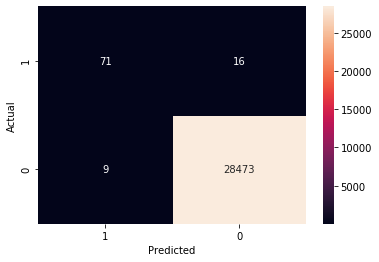

Text(0.5, 15.0, 'Predicted')

In [0]:
# Confusioin Matrix.The accuracy of correctly labeled points for the normal data is very high and is decent for the fradulent data
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')